In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
f1 = h5py.File('../input/electron-photon/download', 'r')
f2 = h5py.File('../input/electron-photon/download_1', 'r')

Electron_X = np.array(f1['X'])
Electron_y = np.array(f1['y'])
Parton_X = np.array(f2['X'])
Parton_y = np.array(f2['y'])
print(Electron_X.shape, Electron_y.shape, Parton_X.shape, Parton_y.shape)

All_X = np.concatenate((Electron_X, Parton_X), axis=0)
All_y = np.concatenate((Electron_y, Parton_y), axis=0)
print(All_X.shape, All_y.shape)
rand_seed = 263
index = np.random.permutation(len(All_y))
All_X, All_y = All_X[index][:,:,:,0], All_y[index]
print(All_X.shape, All_y.shape)

# clear cache to save memory
del Electron_X, Electron_y, Parton_X, Parton_y

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(All_X, All_y, test_size=0.2, random_state=12)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

del All_X, All_y

(249000, 32, 32, 2) (249000,) (249000, 32, 32, 2) (249000,)
(498000, 32, 32, 2) (498000,)
(498000, 32, 32) (498000,)
(398400, 32, 32) (99600, 32, 32)
(398400,) (99600,)


2022-03-25 12:09:57.381502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:09:57.469074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:09:57.469755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 12:09:57.471720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

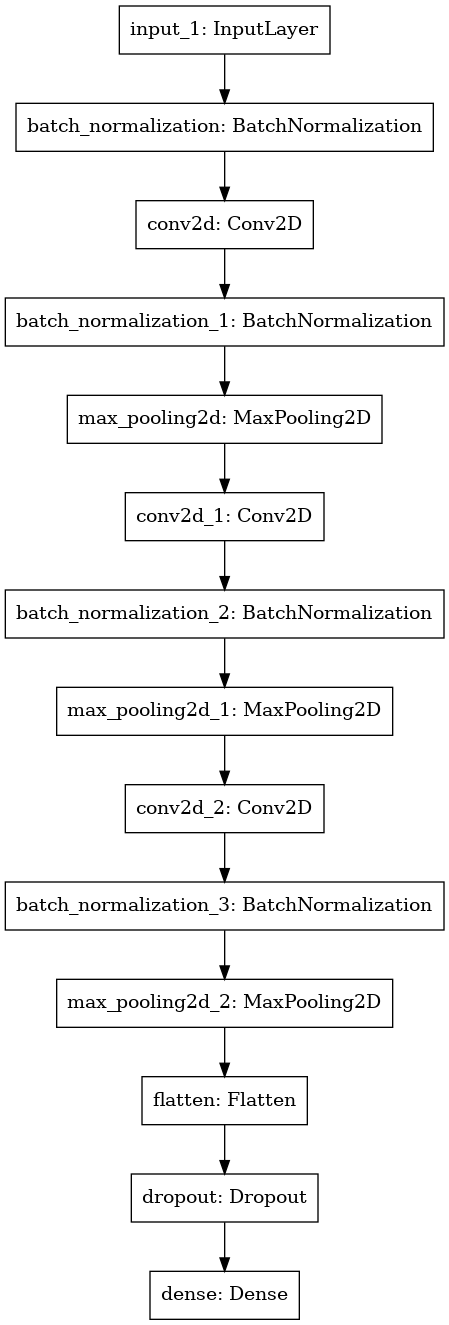

In [3]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers

num_classes = 1
input_shape = (32, 32, 1)
model = Sequential(
    [
        keras.Input(shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, kernel_size=(3,3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Conv2D(128, kernel_size=(3,3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="sigmoid"),
    ]
)
model.summary()
keras.utils.plot_model(model)

In [4]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
opt_func = keras.optimizers.Adam(learning_rate=lr_schedule)

checkpoint_filepath = 'saved_model'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_binary_accuracy',
    save_weights_only=True,
    save_best_only=True)

model.compile(loss='binary_crossentropy',
              optimizer=opt_func,
              metrics=[
                keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
                tf.keras.metrics.AUC(name="auc", from_logits=True),
              ],
             )

history = model.fit(X_train.reshape((-1,32,32,1)),
          y_train,
          epochs=30,
          validation_split=0.2,
          batch_size=32,
          shuffle=True,
          callbacks=[checkpoint_callback])

2022-03-25 12:10:00.569787: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1305477120 exceeds 10% of free system memory.
2022-03-25 12:10:01.892201: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1305477120 exceeds 10% of free system memory.
2022-03-25 12:10:02.847823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-03-25 12:10:04.512379: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9960/9960 [==============================] - 60s 5ms/step - loss: 0.6210 - binary_accuracy: 0.6735 - auc: 0.7207 - val_loss: 0.9409 - val_binary_accuracy: 0.5011 - val_auc: 0.5573
Epoch 2/30
9960/9960 [==============================] - 53s 5ms/step - loss: 0.5910 - binary_accuracy: 0.6993 - auc: 0.7523 - val_loss: 0.6596 - val_binary_accuracy: 0.6607 - val_auc: 0.7619
Epoch 3/30
9960/9960 [==============================] - 52s 5ms/step - loss: 0.5807 - binary_accuracy: 0.7077 - auc: 0.7631 - val_loss: 0.5932 - val_binary_accuracy: 0.7086 - val_auc: 0.7784
Epoch 4/30
9960/9960 [==============================] - 53s 5ms/step - loss: 0.5741 - binary_accuracy: 0.7118 - auc: 0.7699 - val_loss: 0.5753 - val_binary_accuracy: 0.7128 - val_auc: 0.7839
Epoch 5/30
9960/9960 [==============================] - 53s 5ms/step - loss: 0.5687 - binary_accuracy: 0.7155 - auc: 0.7755 - val_loss: 0.5604 - val_binary_accuracy: 0.7187 - val_auc: 0.7873
Epoch 6/30
9960/9960 [==============================] - 

In [5]:
model.load_weights(checkpoint_filepath)
_, accuracy, auc = model.evaluate(X_test.reshape((-1,32,32,1)), y_test)
print(f"Test accuracy: {accuracy}")
print(f"Test AUC: {auc}")

3113/3113 [==============================] - 11s 4ms/step - loss: 0.5513 - binary_accuracy: 0.7324 - auc: 0.8003
Test accuracy: 0.7324497699737549
Test AUC: 0.8002513647079468


dict_keys(['loss', 'binary_accuracy', 'auc', 'val_loss', 'val_binary_accuracy', 'val_auc'])


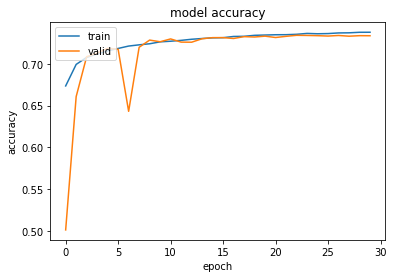

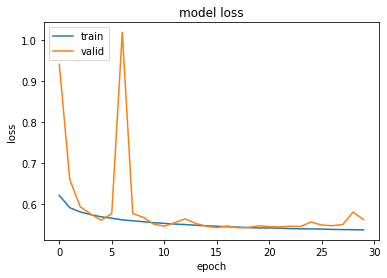

In [6]:
import matplotlib.pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()